In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

!pip install -q optuna

import lightgbm as lgb
from sklearn import metrics

In [2]:
df = pd.read_csv('/kaggle/input/playground-series-s3e25/train.csv')

In [3]:
df.head()
df = df.drop(columns=['id'])


In [4]:
num_features = df.select_dtypes(include=[np.number]).columns
num_features



Index(['allelectrons_Total', 'density_Total', 'allelectrons_Average',
       'val_e_Average', 'atomicweight_Average', 'ionenergy_Average',
       'el_neg_chi_Average', 'R_vdw_element_Average', 'R_cov_element_Average',
       'zaratio_Average', 'density_Average', 'Hardness'],
      dtype='object')

In [5]:
y = df['Hardness']
X = df.drop(columns='Hardness')

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  train_size=0.8/0.9,
                                                  random_state=42)

print(f'Train: {X_train.shape[0]} - {round(X_train.shape[0] / X.shape[0] * 100)}%')
print(f'Test:  {X_test.shape[0]} - {round(X_test.shape[0] / X.shape[0] * 100)}%')
print(f'Val:   {X_val.shape[0]} - {round(X_val.shape[0] / X.shape[0] * 100)}%')

Train: 6474 - 62%
Test:  3123 - 30%
Val:   810 - 8%


In [7]:
num_columns = X.select_dtypes(include="number").columns

# Pipeline for numeric
num_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median"))]
)

# Pipeline for numeric
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_columns),
    ]
)

#  Pandas for output
preprocessor.set_output(transform='pandas')
preprocessor



ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 Index(['allelectrons_Total', 'density_Total', 'allelectrons_Average',
       'val_e_Average', 'atomicweight_Average', 'ionenergy_Average',
       'el_neg_chi_Average', 'R_vdw_element_Average', 'R_cov_element_Average',
       'zaratio_Average', 'density_Average'],
      dtype='object'))])

In [8]:
X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)



In [9]:
def objective(trial):

  # Hyperparams:

  model = lgb.LGBMRegressor(
        n_estimators = 30,
        verbose = -1,
        max_depth = trial.suggest_int('max_depth', 4, 30),
        lambda_l1 = trial.suggest_float('lambda_l1', 1e-5, 1, log=True),
        lambda_l2 = trial.suggest_float('lambda_l2', 1e-5, 1, log=True),
        num_leaves = trial.suggest_int('num_leaves', 5, 120),
        objective = trial.suggest_categorical('objective', ['mse', 'mae', 'huber']),
        alpha = trial.suggest_float('alpha', 1, 20, log=True)
  )


  # Train
  model.fit(X_train, y_train)

  # Model estimation
  y_pred = model.predict(X_val)
  r2 = metrics.r2_score(y_val, y_pred)

  # Mertics:
  return r2

import optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

[I 2024-12-09 01:03:27,334] A new study created in memory with name: no-name-6e72afb9-8ec5-48c7-ba13-a196c4b5a00b
[I 2024-12-09 01:03:27,614] Trial 0 finished with value: 0.49815022781858775 and parameters: {'max_depth': 28, 'lambda_l1': 0.0006166482706247828, 'lambda_l2': 0.10434547612929232, 'num_leaves': 55, 'objective': 'mse', 'alpha': 4.177720916065332}. Best is trial 0 with value: 0.49815022781858775.
[I 2024-12-09 01:03:27,677] Trial 1 finished with value: 0.47099283470513253 and parameters: {'max_depth': 5, 'lambda_l1': 0.3143266222060133, 'lambda_l2': 0.0001891555945791508, 'num_leaves': 60, 'objective': 'mse', 'alpha': 1.359413209872363}. Best is trial 0 with value: 0.49815022781858775.
[I 2024-12-09 01:03:27,820] Trial 2 finished with value: 0.47109213929673877 and parameters: {'max_depth': 12, 'lambda_l1': 1.0754788384291006e-05, 'lambda_l2': 0.09165306369678831, 'num_leaves': 72, 'objective': 'mae', 'alpha': 18.10050486259814}. Best is trial 0 with value: 0.498150227818587

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='l1'>

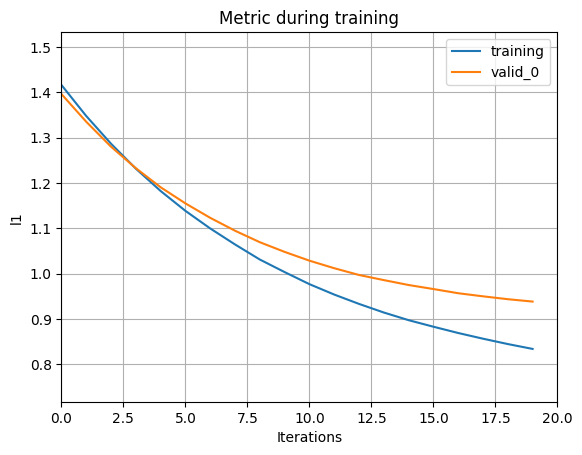

In [10]:
best_params = study.best_params

model = lgb.LGBMRegressor(**best_params,
                          n_estimators = 20,# number of trees
                          verbose=-1)

model.fit(X_train, y_train,
          eval_set=[(X_test, y_test), (X_train, y_train)],
          eval_metric='mae')



lgb.plot_metric(model,metric='l1')



In [11]:
def get_metrics(y_true, y_pred, name="model"):
  df = pd.DataFrame()

  df.loc["MAE", name] = metrics.mean_absolute_error(y_true, y_pred)
  df.loc["RMSE", name] = metrics.mean_squared_error(y_true, y_pred) ** 0.5
  df.loc["R2", name] = metrics.r2_score(y_true, y_pred)

  return df.round(2)
    
_metrics = pd.DataFrame()

_metrics["train"] = get_metrics(y_train, model.predict(X_train))
_metrics["test"] = get_metrics(y_test, model.predict(X_test))

_metrics    

,train,test
MAE,0.83,0.94
RMSE,1.08,1.22
R2,0.59,0.45


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

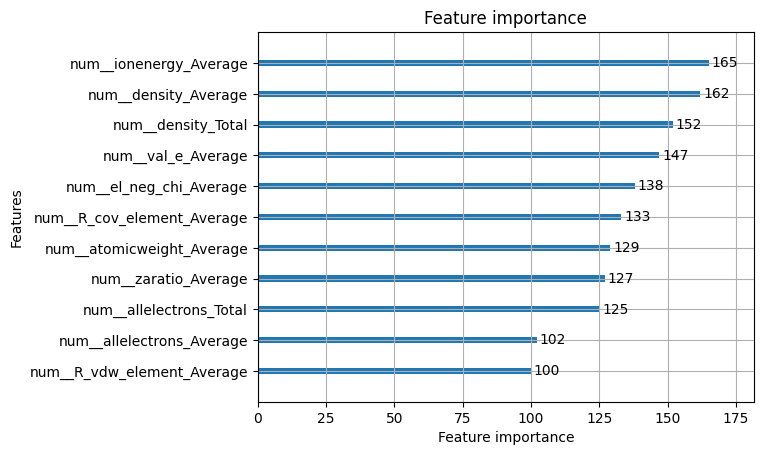

In [12]:
optuna.visualization.plot_param_importances(study)
lgb.plot_importance(model)



In [13]:


len(model.evals_result_['training']['l1'])



20